In [1]:
import numpy as np
import pickle
import torch
import math
import random
from torch import nn, optim
import matplotlib.pyplot as plt
from mutect3.validation import TrainingMetrics
from mutect3 import data, validation, tensors

# we need to explicitly import in order for unpickling to work
from mutect3.tensors import Datum, SiteInfo, MutectInfo 
from mutect3.networks import ReadSetClassifier

%matplotlib inline

In [2]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
BATCH_SIZE = 64

In [ ]:
"""
table_dir = '/Users/davidben/broad/mutect3/tables/'
pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
    print("Generating tensors for " + dream)
    
    tumor_table = table_dir + dream + '-tumor.table'
    normal_table = table_dir + dream + '-normal.table'
    
    # we form a few kinds of training data: tumor data using the normal 
    # (the normal doesn't change the format but helps make better truth guesses)
    print("Generating and pickling tumor tensors for training using tumor and normal")
    pair_train_pickle = pickle_dir + dream + '-pair-train.pickle'
    pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
    with open(pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data, f)
        
    print("Generating and pickling small (by 10x) tumor tensors for training using tumor and normal")
    small_pair_train_pickle = pickle_dir + dream + '-small-pair-train.pickle'
    random.shuffle(pair_train_data)
    original_size = len(pair_train_data)
    with open(small_pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data[:int(original_size/10)], f)
    
    #print("Generating and pickling tumor tensors for training using only tumor")
    #tumor_train_pickle = dir + dream + '-tumor-train.pickle'
    #tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
    #with open(tumor_train_pickle, 'wb') as f:
    #    pickle.dump(tumor_train_data, f)
    
    print("Generating and pickling normal tensors for training using only normal")
    normal_train_pickle = pickle_dir + dream + '-normal-train.pickle'
    normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
    with open(normal_train_pickle, 'wb') as f:
        pickle.dump(normal_train_data, f)
    
    print("Generating and pickling tumor tensors for testing using STATUS labels")
    test_pickle = pickle_dir + dream + '-test.pickle'
    test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
    with open(test_pickle, 'wb') as f:
        pickle.dump(test_data, f)
        
    print("Generating and pickling small (by 10x) tumor tensors for for testing using STATUS labels")
    small_test_pickle = pickle_dir + dream + '-small-test.pickle'
    random.shuffle(test_data)
    original_size = len(test_data)
    with open(small_test_pickle, 'wb') as f:
        pickle.dump(test_data[:int(original_size/10)], f)
"""

In [3]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    train_optimizer = torch.optim.Adam(model.training_parameters())
    valid_optimizer = torch.optim.Adam(model.calibration_parameters())
    
    # we optimize the AF spectra -- without supervision -- on the test set
    test_optimizer = torch.optim.Adam(model.spectra_parameters())
    
    training_metrics = TrainingMetrics()
    for epoch in range(1, num_epochs + 1):
        print("Epoch " + str(epoch))
        
        # training epoch, then validation epoch
        for train_vs_valid in [True, False]:  
            loader = train_loader if train_vs_valid else valid_loader
            optimizer = train_optimizer if train_vs_valid else valid_optimizer
            
            if train_vs_valid:
                model.training_mode()
            else:
                model.learn_calibration_mode()
                
            epoch_loss = 0
            for batch_number, batch in enumerate(loader):
                predictions, _ = model(batch)              
                loss = criterion(predictions, batch.labels())
                epoch_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            training_metrics.add(TrainingMetrics.NLL, "training" if train_vs_valid else "validating", epoch_loss / (len(loader)*BATCH_SIZE))
        
        # done with training and validation for this epoch, now update the posterior model (for later use) on the test set
        optimal_f = validation.get_optimal_f_score_and_train_spectra(model, test_loader, optimizer=test_optimizer)
        training_metrics.add(TrainingMetrics.F, "test", optimal_f)
        #done with epoch
    # model is trained
    return training_metrics

In [4]:
EPOCHS = 50

def run_evaluation(training_pickles, test_pickle, num_epochs=EPOCHS):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect_info().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    # Learn model
    train_loader, valid_loader, test_loader = data.make_data_loaders(train, valid, test)
    model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10], {'normal_artifact'}).float()
    training_metrics = train_model(model, train_loader, valid_loader, test_loader, num_epochs)
    training_metrics.plot_all_metrics()
    model.get_prior_model().plot_spectra()

    logit_threshold = model.calculate_logit_threshold(test_loader)
    print("Optimal logit threshold: " + str(logit_threshold))
    
    validation.show_validation_plots(model, test_loader, logit_threshold)

    return model
        

In [5]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_1_SMALL_PAIR = DIR + 'dream1-small-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_1_SMALL_TEST = DIR + 'dream1-small-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 50)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 19 PASS variants labelled as artifacts.
Training data includes 168835 artifacts labelled as good variants.


/Users/davidben/broad/mutect3/mutect3/networks.py:75: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.confidence = nn.Parameter(torch.sqrt(torch.range(0, MAX_ALT)), requires_grad=False)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Optimal logit threshold: 0.06901069186205686
Minimum distance to sens=1, prec=1 corner: 0.04229856553383174


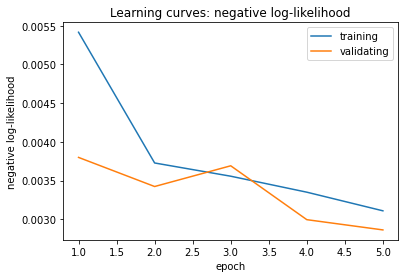

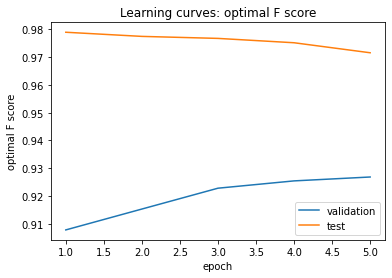

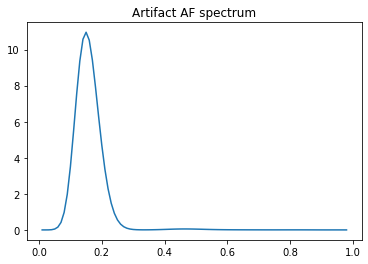

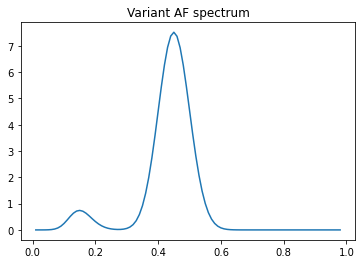

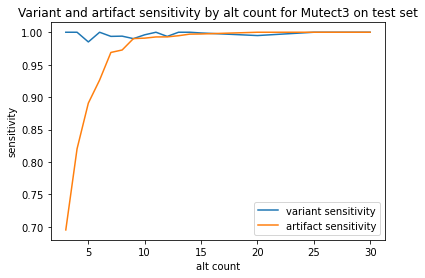

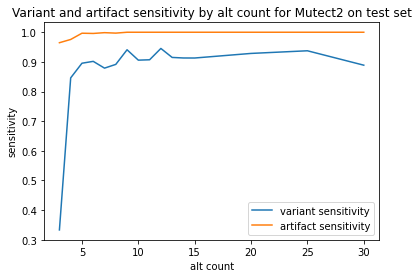

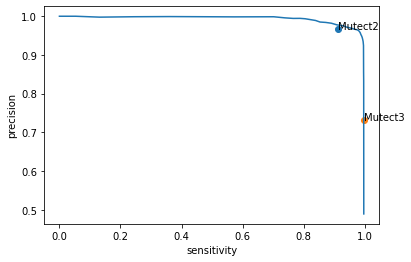

In [7]:
# SGD temperatures and priors
#leaky_relu and learnable alt count-dependent confidence
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 5)

Loading datasets from pickled files
Dataset sizes -- training: 17221, validation: 1914, test: 2547
Training data includes 3 PASS variants labelled as artifacts.


/Users/davidben/broad/mutect3/mutect3/networks.py:174: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.confidence = nn.Parameter(torch.sqrt(torch.range(0, MAX_ALT)), requires_grad=False)


Epoch 1
Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)
tensor(-0.0407)
tensor([ 0.0219, -0.0050, -0.0396, -0.0578, -0.0594, -0.0481, -0.0303, -0.0124,
         0.0017,  0.0111,  0.0167,  0.0198,  0.0215,  0.0223,  0.0227,  0.0229,
         0.0229,  0.0230,  0.0230,  0.0230])
tensor([ 0.0261, -0.0017, -0.0509, -0.0810, -0.0769, -0.0536, -0.0294, -0.0096,
         0.0049,  0.0145,  0.0203,  0.0236,  0.0254,  0.0264,  0.0268,  0.0270,
         0.0270,  0.0270,  0.0270,  0.0270])
tensor(-0.0477)
tensor([ 0.0212, -0.0068, -0.0408, -0.0572, -0.0575, -0.0474, -0.0310, -0.0130,
         0.0020,  0.0122,  0.0179,  0.0207,  0.0219,  0.0223,  0.0225,  0.0226,
         0.0226,  0.0226,  0.0226,  0.0226])
tensor([ 0.026

tensor(-0.0273)
tensor([ 0.0202, -0.0088, -0.0351, -0.0471, -0.0503, -0.0450, -0.0318, -0.0154,
        -0.0009,  0.0085,  0.0142,  0.0175,  0.0195,  0.0208,  0.0216,  0.0221,
         0.0223,  0.0225,  0.0226,  0.0227])
tensor([ 0.0237, -0.0120, -0.0676, -0.0827, -0.0629, -0.0397, -0.0202, -0.0043,
         0.0072,  0.0147,  0.0193,  0.0220,  0.0236,  0.0246,  0.0252,  0.0255,
         0.0257,  0.0259,  0.0260,  0.0260])
tensor(-0.0565)
tensor([ 0.0205,  0.0010, -0.0274, -0.0447, -0.0508, -0.0455, -0.0317, -0.0156,
        -0.0019,  0.0068,  0.0121,  0.0154,  0.0175,  0.0190,  0.0200,  0.0207,
         0.0210,  0.0212,  0.0212,  0.0213])
tensor([ 0.0262, -0.0077, -0.0597, -0.0819, -0.0735, -0.0514, -0.0264, -0.0056,
         0.0079,  0.0157,  0.0202,  0.0228,  0.0245,  0.0257,  0.0265,  0.0270,
         0.0273,  0.0274,  0.0274,  0.0275])
tensor(-0.0400)
tensor([ 0.0201, -0.0193, -0.0603, -0.0683, -0.0563, -0.0374, -0.0179, -0.0016,
         0.0094,  0.0158,  0.0193,  0.0209,  0.0216,

tensor(0.2078)
tensor([ 0.0319, -0.0059, -0.0520, -0.0766, -0.0832, -0.0726, -0.0483, -0.0202,
         0.0026,  0.0160,  0.0235,  0.0274,  0.0294,  0.0306,  0.0315,  0.0323,
         0.0329,  0.0334,  0.0336,  0.0337])
tensor([ 0.0133, -0.0032, -0.0431, -0.0673, -0.0483, -0.0193, -0.0008,  0.0079,
         0.0107,  0.0122,  0.0129,  0.0133,  0.0135,  0.0137,  0.0139,  0.0140,
         0.0141,  0.0142,  0.0142,  0.0142])
tensor(0.2321)
tensor([ 0.0334,  0.0001, -0.0486, -0.0776, -0.0871, -0.0796, -0.0562, -0.0256,
         0.0008,  0.0163,  0.0246,  0.0287,  0.0310,  0.0325,  0.0336,  0.0343,
         0.0347,  0.0348,  0.0349,  0.0349])
tensor([ 0.0115, -0.0112, -0.0311, -0.0398, -0.0346, -0.0189, -0.0045,  0.0036,
         0.0066,  0.0079,  0.0085,  0.0088,  0.0094,  0.0101,  0.0109,  0.0117,
         0.0123,  0.0128,  0.0130,  0.0130])
tensor(0.1882)
tensor([ 0.0260, -0.0380, -0.0862, -0.0901, -0.0703, -0.0449, -0.0207, -0.0005,
         0.0127,  0.0201,  0.0239,  0.0255,  0.0264,  0

Optimal logit threshold: 0.08821096271276474


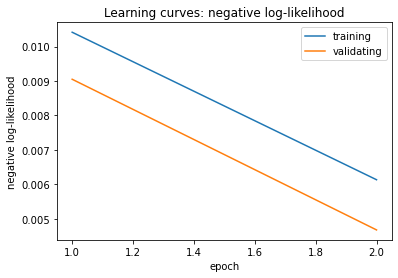

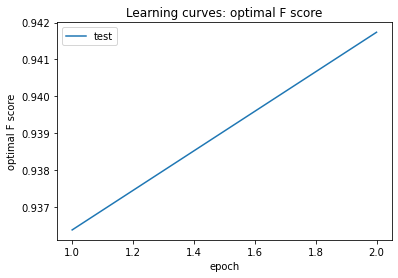

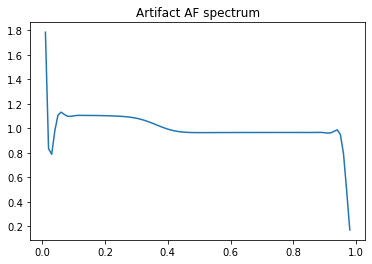

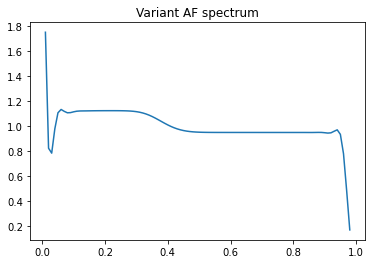

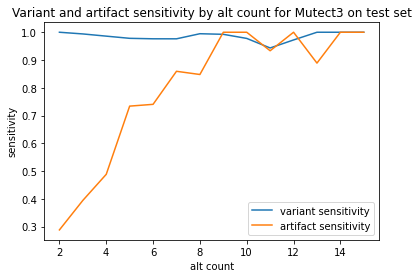

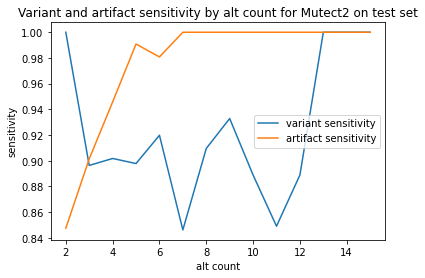

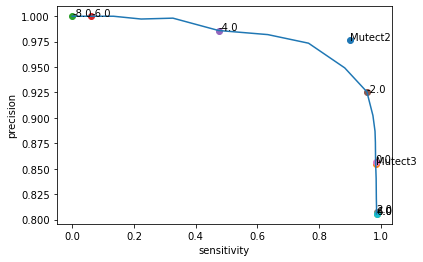

In [6]:
# SGD temperatures and priors
#leaky_relu and learnable alt count-dependent confidence
# spectra refactoring
trained_model = run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 15)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)